<a href="https://colab.research.google.com/github/ToyzZone/RedDB-analysis/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import necessary libraries

In [ ]:
!pip install rdkit
!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 15.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.8/481.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 16.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.8/105.8 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# from rdkit import Chem
# import rdkit
# from rdkit.Chem import Fragments, Lipinski
# from rdkit.Chem import Crippen, MolSurf
# import selfies as sf
import pandas as pd
import numpy as np
import sklearn
import pycaret
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sn
from collections import Counter

Import the data

In [ ]:
data0 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/assignment/data_list/data0.csv')
data1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/assignment/data_list/data1.csv')
data2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/assignment/data_list/data2.csv')
data3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/assignment/data_list/data3.csv')
data4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/assignment/data_list/data4.csv')
data5 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/assignment/data_list/data5.csv')
data6 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/assignment/data_list/data6.csv')
data7 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/assignment/data_list/data7.csv')
data8 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/assignment/data_list/data8.csv')
data9 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/assignment/data_list/data9.csv')


In [ ]:
df = pd.concat([data0, data1, data2, data3, data4, data5, data6, data7, data8, data9], ignore_index=True)

Declare X

In [ ]:
features_need_scale = [
                  'nmr_isotropic_shielding',
                  'nmr_anisotropy',
                  'homo_f_NN',
                  'homo_f_NS',
                  'homo_f_SN',
                  'homo_f_SS',
                  'lumo_f_NN',
                  'lumo_f_NS',
                  'lumo_f_SN',
                  'lumo_f_SS',
                  'molLogP',
                  'peoe_vsa1',
                  'solubilityAqSolPred',
]
X = df[features_need_scale]
X.shape

(976681, 13)

In [ ]:
X.describe().T\
        .style.bar(subset=['mean'], color=px.colors.qualitative.G10[0])\
        .background_gradient(subset=['std'], cmap='Greens')\
        .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
nmr_isotropic_shielding,976681.000000,72.251401,76.711452,-358.226300,25.377700,57.736400,89.311900,576.959100
nmr_anisotropy,976681.000000,108.773534,118.548753,0.071400,16.307500,87.378000,143.043900,1434.076700
homo_f_NN,976681.000000,0.031680,0.055563,-0.026500,0.000600,0.007300,0.041300,0.815900
homo_f_NS,976681.000000,-0.000000,0.033459,-0.855500,-0.006600,0.000000,0.005600,0.425000
homo_f_SN,976681.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
homo_f_SS,976681.000000,0.031680,0.042606,-0.391700,0.001200,0.013900,0.050800,0.949200
lumo_f_NN,976681.000000,0.031680,0.052747,-0.816700,0.000600,0.007900,0.044400,1.804700
lumo_f_NS,976681.000000,0.000000,0.033459,-0.425000,-0.005600,0.000000,0.006600,0.855500
lumo_f_SN,976681.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
lumo_f_SS,976681.000000,0.031680,0.042606,-0.391700,0.001200,0.013900,0.050800,0.949200


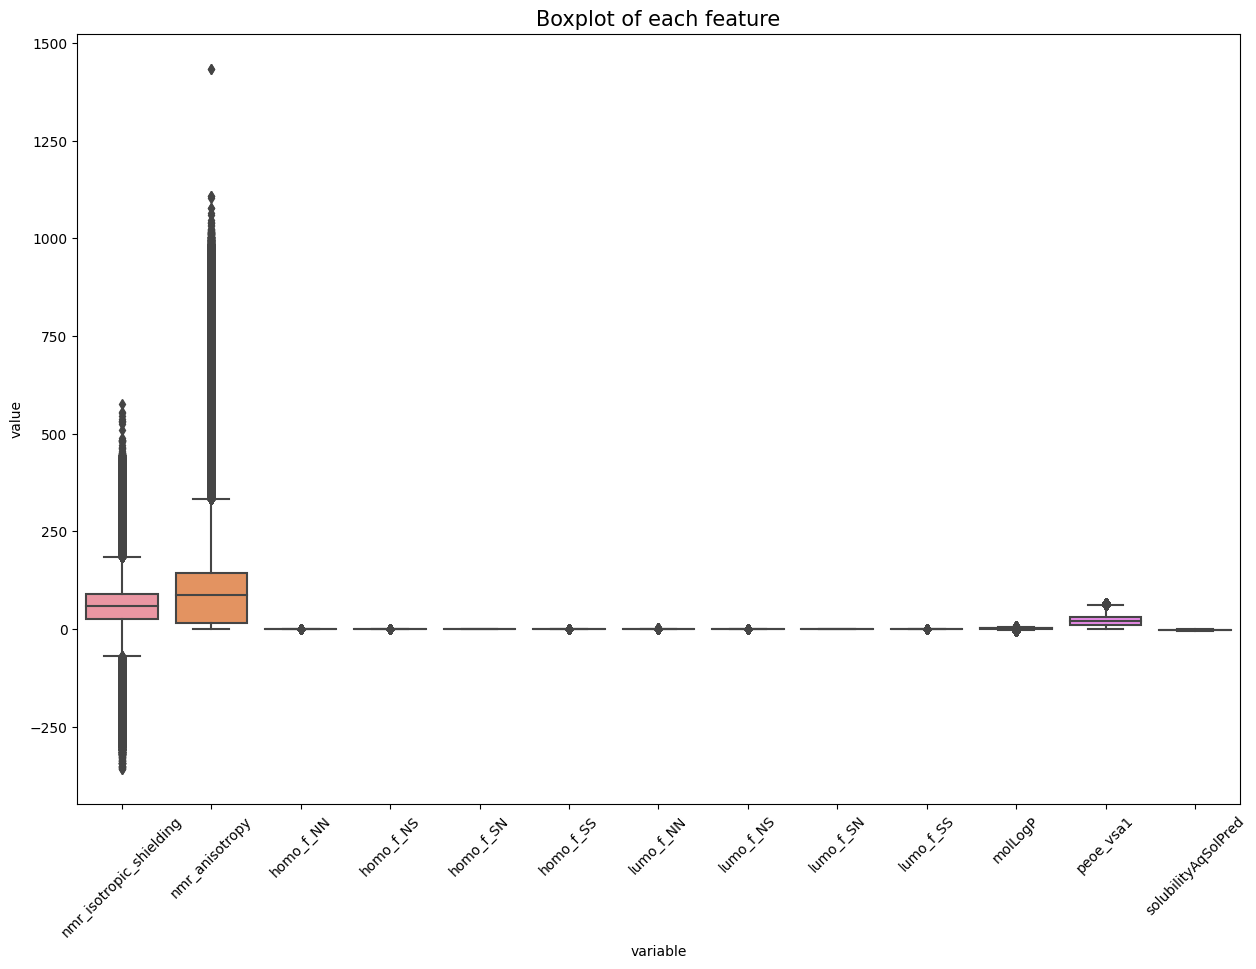

In [ ]:
plt.figure(figsize=(15,10)) 
sn.boxplot(x="variable", y="value", data=pd.melt(X)).set_title('Boxplot of each feature',size=15)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# X = X.drop('nmr_isotropic_shielding', axis = 1)
# X = X.drop('nmr_anisotropy', axis = 1)
# plt.figure(figsize=(15,10)) 
# sn.boxplot(x="variable", y="value", data=pd.melt(X)).set_title('Boxplot of each feature',size=15)
# plt.xticks(rotation=45)
# plt.show()


As you can see the 'nmr_isotropic_shielding' and the 'nmr_anisotropy' are very noisy, let put them in the log function to reduce the noise.
Plus also homo_f_SN and lumu_f_SN are 0 for every value, we can take them out

In [ ]:
X = X.drop('homo_f_SN', axis = 1)
X = X.drop('lumo_f_SN', axis = 1) 


In [ ]:
X_scaled = X
X_scaled['nmr_isotropic_shielding'] = np.log(X_scaled['nmr_isotropic_shielding']+400)
X_scaled['nmr_anisotropy'] = np.log(X_scaled['nmr_anisotropy'])
X_scaled['peoe_vsa1'] = np.log(X_scaled['peoe_vsa1']+ 1)

In [ ]:
X_scaled.describe().T\
        .style.bar(subset=['mean'], color=px.colors.qualitative.G10[0])\
        .background_gradient(subset=['std'], cmap='Greens')\
        .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
nmr_isotropic_shielding,976681.000000,6.144911,0.159136,3.732267,6.052977,6.126293,6.193000,6.884445
nmr_anisotropy,976681.000000,4.044887,1.317670,-2.639457,2.791625,4.470244,4.963152,7.268277
homo_f_NN,976681.000000,0.031680,0.055563,-0.026500,0.000600,0.007300,0.041300,0.815900
homo_f_NS,976681.000000,-0.000000,0.033459,-0.855500,-0.006600,0.000000,0.005600,0.425000
homo_f_SS,976681.000000,0.031680,0.042606,-0.391700,0.001200,0.013900,0.050800,0.949200
lumo_f_NN,976681.000000,0.031680,0.052747,-0.816700,0.000600,0.007900,0.044400,1.804700
lumo_f_NS,976681.000000,0.000000,0.033459,-0.425000,-0.005600,0.000000,0.006600,0.855500
lumo_f_SS,976681.000000,0.031680,0.042606,-0.391700,0.001200,0.013900,0.050800,0.949200
molLogP,976681.000000,1.070014,1.803320,-5.903200,-0.102400,1.244000,2.194200,6.307000
peoe_vsa1,976681.000000,2.553035,1.253708,0.000000,2.417079,3.064610,3.454396,4.221513


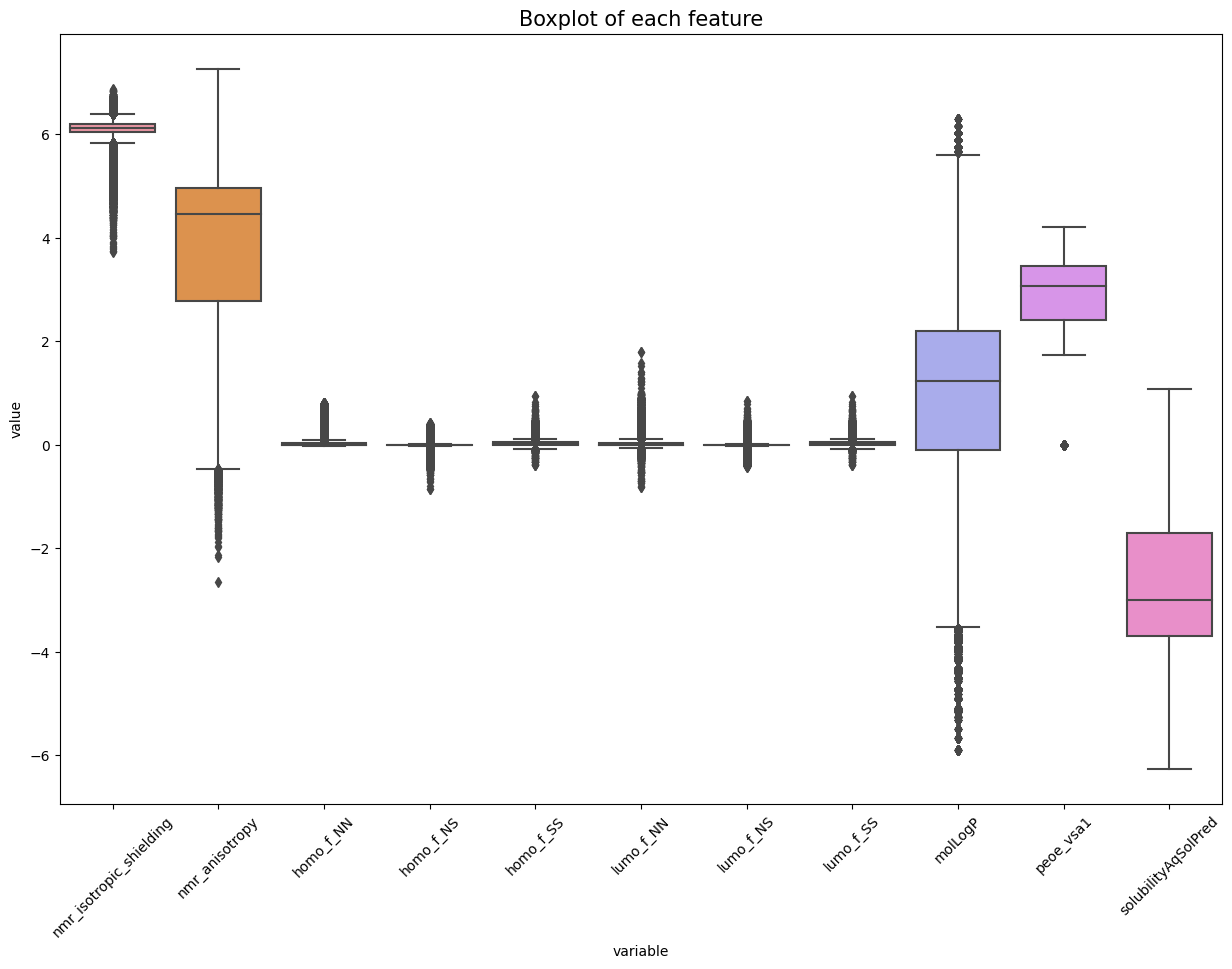

In [ ]:
plt.figure(figsize=(15,10)) 
sn.boxplot(x="variable", y="value", data=pd.melt(X)).set_title('Boxplot of each feature',size=15)
plt.xticks(rotation=45)
plt.show()

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_scaled)
X_scaled = pd.DataFrame(X_scaled, columns = [
                  'nmr_isotropic_shielding',
                  'nmr_anisotropy',
                  'homo_f_NN',
                  'homo_f_NS',
                  'homo_f_SS',
                  'lumo_f_NN',
                  'lumo_f_NS',
                  'lumo_f_SS',
                  'molLogP',
                  'peoe_vsa1',
                  'solubilityAqSolPred',
], index=None)
X_scaled.head()

,nmr_isotropic_shielding,nmr_anisotropy,homo_f_NN,homo_f_NS,homo_f_SS,lumo_f_NN,lumo_f_NS,lumo_f_SS,molLogP,peoe_vsa1,solubilityAqSolPred
0,0.998069,-1.090710,1.785728,1.936725,0.807869,-0.575956,-1.936725,0.807869,-0.5465,-2.036388,1.752344
1,-1.194930,0.730129,-0.089622,-1.536224,1.089520,1.854505,1.536224,1.089520,-0.5465,-2.036388,1.752344
2,-0.305276,0.716065,0.115550,-2.749664,2.310007,3.610048,2.749664,2.310007,-0.5465,-2.036388,1.752344
3,-0.305245,0.716108,0.115550,-2.749664,2.310007,3.610048,2.749664,2.310007,-0.5465,-2.036388,1.752344
4,-1.195015,0.730008,-0.089622,-1.536224,1.089520,1.854505,1.536224,1.089520,-0.5465,-2.036388,1.752344


In [ ]:
X.describe().T\
        .style.bar(subset=['mean'], color=px.colors.qualitative.G10[0])\
        .background_gradient(subset=['std'], cmap='Greens')\
        .background_gradient(subset=['50%'], cmap='BuGn')


# X_scaled.describe().T\
#         .style.bar(subset=['mean'], color=px.colors.qualitative.G10[0])\
#         .background_gradient(subset=['std'], cmap='Greens')\
#         .background_gradient(subset=['50%'], cmap='BuGn')


,count,mean,std,min,25%,50%,75%,max
nmr_isotropic_shielding,976681.000000,6.144911,0.159136,3.732267,6.052977,6.126293,6.193000,6.884445
nmr_anisotropy,976681.000000,4.044887,1.317670,-2.639457,2.791625,4.470244,4.963152,7.268277
homo_f_NN,976681.000000,0.031680,0.055563,-0.026500,0.000600,0.007300,0.041300,0.815900
homo_f_NS,976681.000000,-0.000000,0.033459,-0.855500,-0.006600,0.000000,0.005600,0.425000
homo_f_SS,976681.000000,0.031680,0.042606,-0.391700,0.001200,0.013900,0.050800,0.949200
lumo_f_NN,976681.000000,0.031680,0.052747,-0.816700,0.000600,0.007900,0.044400,1.804700
lumo_f_NS,976681.000000,0.000000,0.033459,-0.425000,-0.005600,0.000000,0.006600,0.855500
lumo_f_SS,976681.000000,0.031680,0.042606,-0.391700,0.001200,0.013900,0.050800,0.949200
molLogP,976681.000000,1.070014,1.803320,-5.903200,-0.102400,1.244000,2.194200,6.307000
peoe_vsa1,976681.000000,2.553035,1.253708,0.000000,2.417079,3.064610,3.454396,4.221513


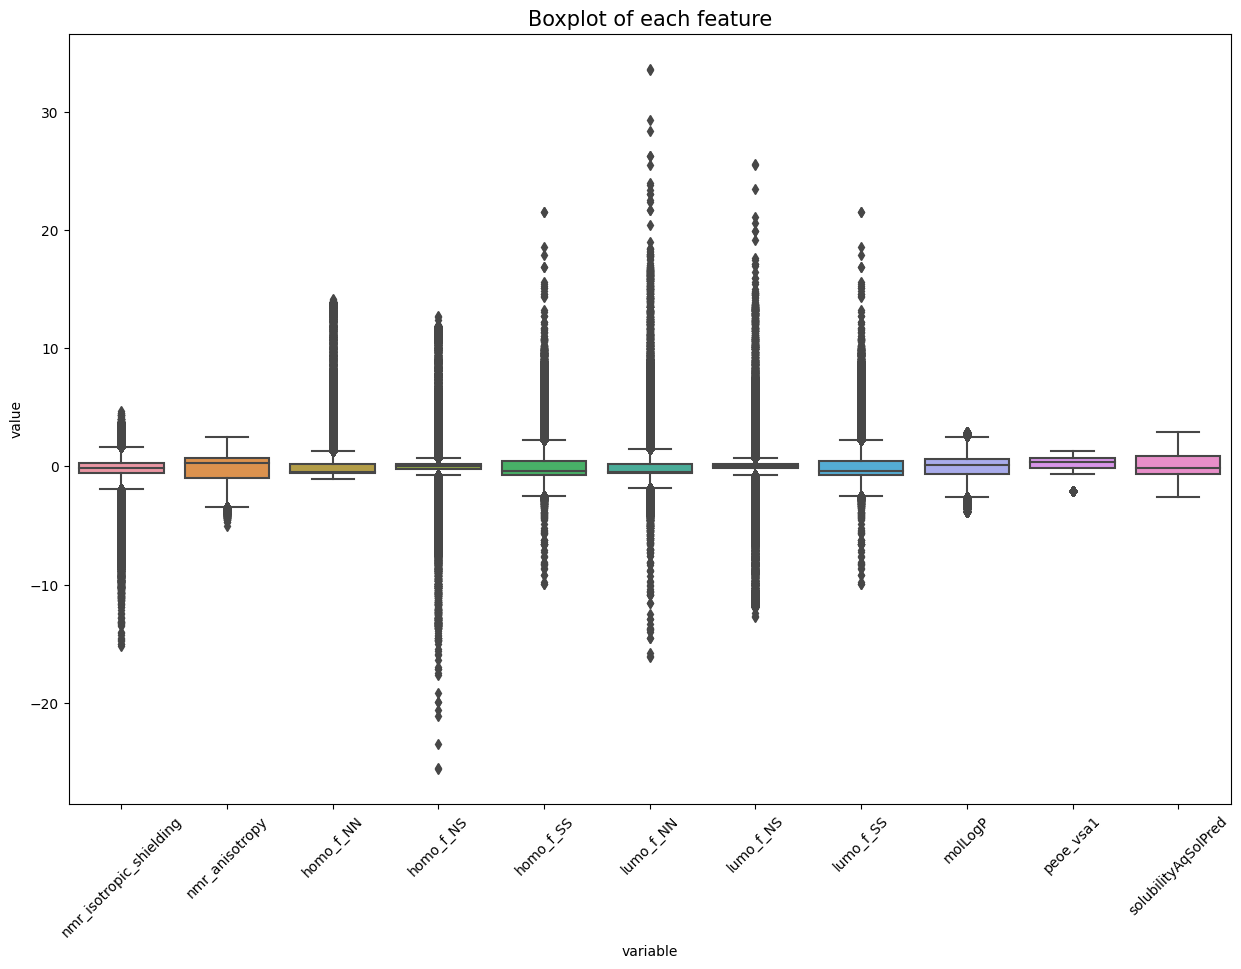

In [ ]:
plt.figure(figsize=(15,10)) 
sn.boxplot(x="variable", y="value", data=pd.melt(X_scaled)).set_title('Boxplot of each feature',size=15)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# figure = plt.figure(figsize=(16, 18))

# count = 0
# for i in range(len(features_need_scale)):
#     feat_name = features_need_scale[i]
#     plt.subplot(13, 1, count+1)
#     plt.hist(X[feat_name], bins=100)
#     plt.title(f'{feat_name}')
#     count += 1
# figure.tight_layout(h_pad=1.0, w_pad=0.8)
# plt.show()

KeyboardInterrupt: ignored

<Figure size 1200x1000 with 0 Axes>

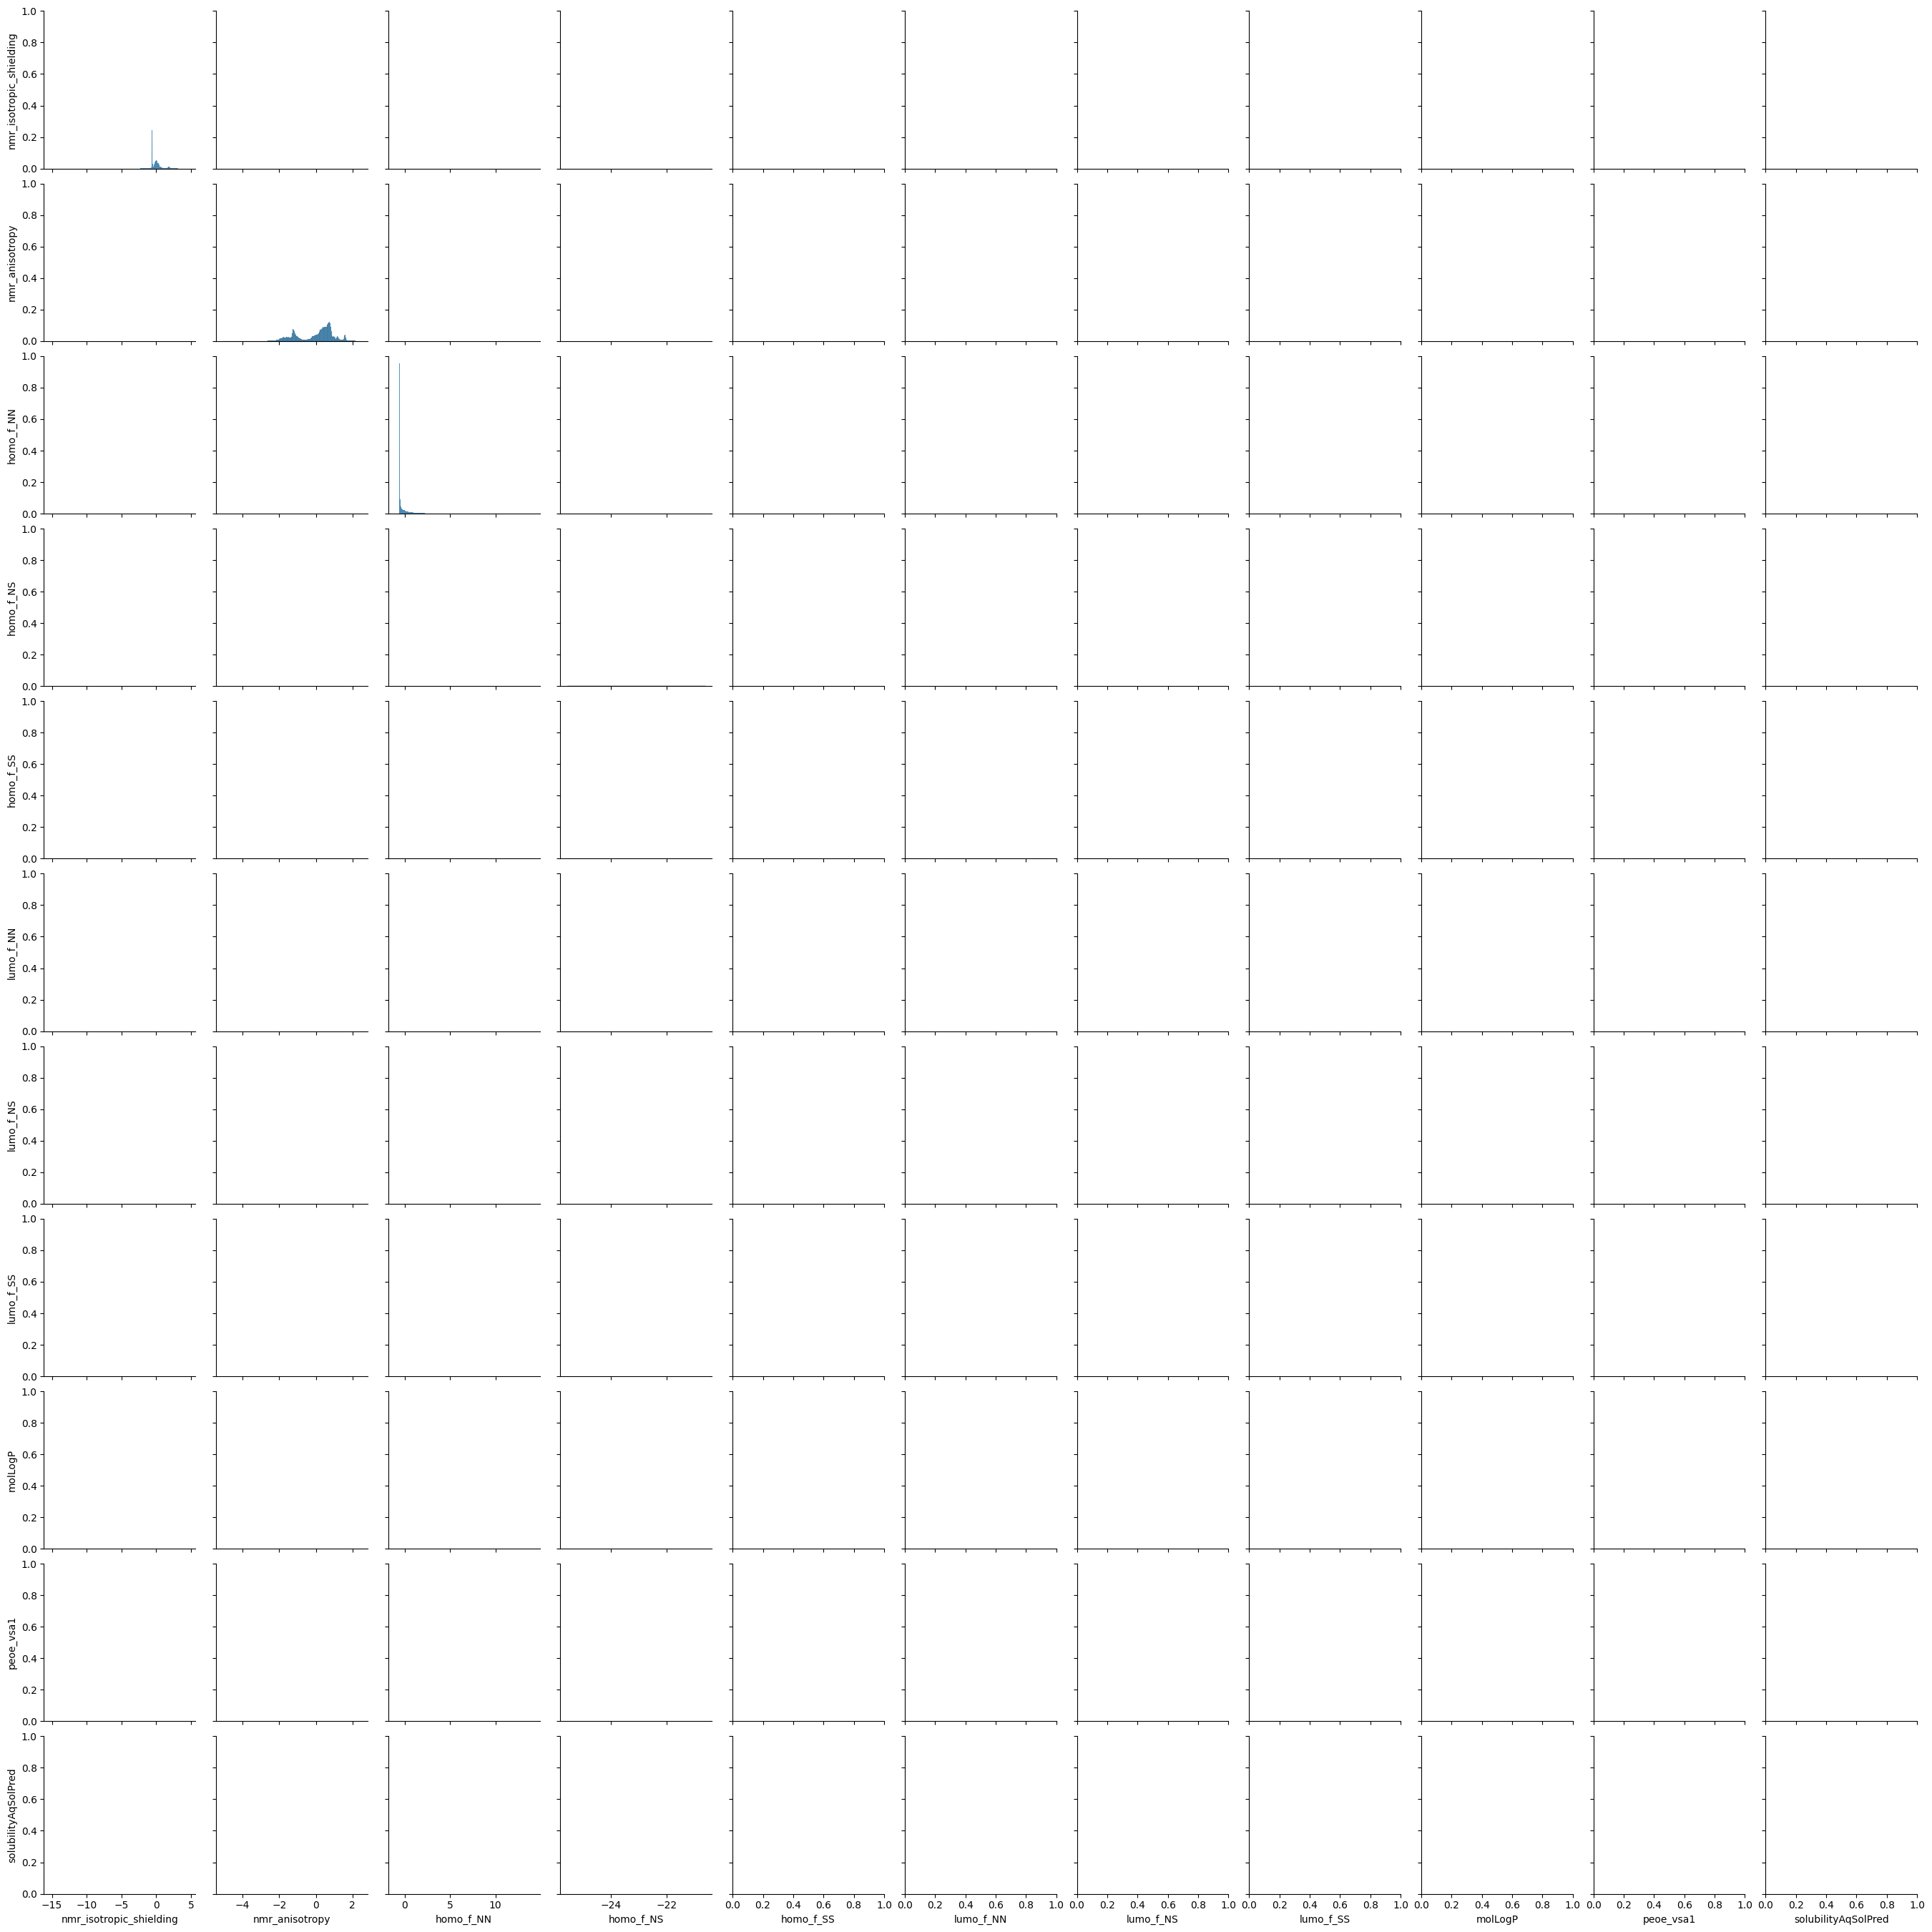

In [ ]:
plt.figure(figsize=(12,10))
sn.pairplot(X_scaled)
plt.title("Data relationship")
plt.legend("target")
plt.tight_layout()
plt.plot()
plt.show()

We need to determine how many clusters in this dataset, I'll run elbow algorithm 

In [ ]:
X = X.iloc[:100000,:]
X_scaled = X_scaled.iloc[:100000,:]
print(X.shape,X_scaled.shape)

In [ ]:
# inertias_X = []
# silhouette_scores_X = []
# inertias_X_scaled = []
# silhouette_scores_X_scaled = []


# n_clusters_range = range(6, 61) # try cluster numbers from 6 to 60
# #need to run smaller

# for n_clusters in n_clusters_range:
#     kmeans = KMeans(n_clusters=n_clusters, random_state=0)
#     kmeans.fit(X)
#     inertias_X.append(kmeans.inertia_)
#     cluster_labels = kmeans.labels_
#     silhouette_avg = silhouette_score(X, cluster_labels)
#     silhouette_scores_X.append(silhouette_avg)
#     X_file = pd.DataFrame({'Cluster Number': [n_clusters],
#                        'Inertia': [kmeans.inertia_],
#                        'Silhouette Score': [silhouette_avg]}, index=None)

#     X_file.to_csv('/content/drive/MyDrive/Colab Notebooks/checking output/X/' + str(n_clusters) + '.csv')


#     kmeans.fit(X_scaled)
#     inertias_X_scaled.append(kmeans.inertia_)
#     cluster_labels = kmeans.labels_
#     silhouette_avg = silhouette_score(X_scaled, cluster_labels)
#     silhouette_scores_X_scaled.append(silhouette_avg)
#     X_scaled_file = pd.DataFrame({'Cluster Number': [n_clusters],
#                               'Inertia': [kmeans.inertia_],
#                               'Silhouette Score': [silhouette_avg]}, index=None)
#     X_scaled_file.to_csv('/content/drive/MyDrive/Colab Notebooks/checking output/X_scaled/' + str(n_clusters) + '.csv')





In [ ]:
# plt.plot(n_clusters_range, inertias_X, 'o-')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Average Squared Distance from Clusters - Inertia')
# plt.title('Elbow Method for Optimal Number of Clusters')
# plt.show()

# plt.plot(n_clusters_range, silhouette_scores_X, 'bx-')
# plt.xlabel('Number of clusters')
# plt.ylabel('Average silhouette score')
# plt.title('Silhhouette Score for Each Number of Clusters')
# plt.show()

# plt.plot(n_clusters_range, inertias_X_scaled, 'o-')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Average Squared Distance from Clusters - Inertia')
# plt.title('Elbow Method for Optimal Number of Clusters')
# plt.show()

# plt.plot(n_clusters_range, silhouette_scores_X_scaled, 'bx-')
# plt.xlabel('Number of clusters')
# plt.ylabel('Average silhouette score')
# plt.title('Silhhouette Score for Each Number of Clusters')
# plt.show()


In [ ]:
# n_clusters_range = range(6, 31)

# silhouette_scores = []

# for n_clusters in n_clusters_range:
#     kmeans = KMeans(n_clusters=n_clusters)
#     kmeans.fit(X_scaled)
#     cluster_labels = kmeans.labels_
#     silhouette_avg = silhouette_score(X_scaled, cluster_labels)
#     silhouette_scores.append(silhouette_avg)

# plt.plot(n_clusters_range, silhouette_scores, 'bx-')
# plt.xlabel('Number of clusters')
# plt.ylabel('Average silhouette score')
# plt.show()


In [ ]:
# # scaler = StandardScaler()
# # X_scaled = scaler.fit_transform(X)

# # X_Kmeans = X_scaled

# # kmeans = KMeans(n_clusters = 30,random_state = 20)
# # kmeans.fit(X_Kmeans)

# print(kmeans.inertia_)
# #print(kmeans.cluster_centers_)

# print(Counter(kmeans.labels_))


# #X['label'] = kmeans.labels_




In [ ]:
# cross_val_score(kmeans, X_Kmeans)
# dbscan.fit(X_dbscan)

# print(print(Counter(dbscan.labels_)))



In [ ]:
# label = kmeans.labels_
# silhouette_score(X.iloc[:100000,],label[:100000])

In [ ]:
# plt.figure(figsize=(12,10))
# sn.pairplot(X)
# plt.title("Data relationship")
# plt.legend("target")
# plt.tight_layout()
# plt.plot()
# plt.show()

In [ ]:
# pca = PCA(n_components= 2)

# X_Kmeans = pca.fit_transform(X_Kmeans)

In [ ]:
# PCA_K = pd.DataFrame(X_Kmeans, columns = ['pca0','pca1'])
# PCA_K['label'] = kmeans.labels_
# PCA_K

In [ ]:
# from collections import Counter
# counts = Counter(kmeans.labels_)
# print(counts)

In [ ]:
# PCA_K.describe()

In [ ]:
# import matplotlib.pyplot as plt

# colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'pink', 'brown']

# fig, ax = plt.subplots()

# color_label = []
# for index, row in PCA_K.iterrows():
#   color_index = row['label']
#   color_label.append(colors[int(color_index)])

# ax.scatter(PCA_K['pca0'],PCA_K['pca1'], c=color_label)
# plt.xlabel('PCA0')
# plt.ylabel('PCA1')
# plt.show()

In [ ]:
# labels = kmeans.labels_
# X['label'] = labels
# df['label'] = labels
# # print(X.head())
# # print(df.head())
# group0 = df.loc[df['label'] == 0, :] 
# group1 = df.loc[df['label'] == 1, :]
# group2 = df.loc[df['label'] == 2, :]
# group3 = df.loc[df['label'] == 3, :]
# group4 = df.loc[df['label'] == 4, :]
# group5 = df.loc[df['label'] == 5, :]
# group6 = df.loc[df['label'] == 6, :]
# group7 = df.loc[df['label'] == 7, :]

In [ ]:
# from rdkit import Chem
# from rdkit.Chem import Draw



# for index ,row in group0.iloc[:10,:].iterrows():

#     smiles_str = row['smiles']
#     mol = Chem.MolFromSmiles(smiles_str)

#     path = '/content/drive/MyDrive/Colab Notebooks/assignment/output_image1/group0/'
#     filename = f'molecule_{index}.png'
#     Draw.MolToFile(mol, path+filename)

# for index ,row in group1.iloc[:10,:].iterrows():

#     smiles_str = row['smiles']
#     mol = Chem.MolFromSmiles(smiles_str)

#     path = '/content/drive/MyDrive/Colab Notebooks/assignment/output_image1/group1/'
#     filename = f'molecule_{index}.png'
#     Draw.MolToFile(mol, path+filename)

# for index ,row in group2.iloc[:10,:].iterrows():

#     smiles_str = row['smiles']
#     mol = Chem.MolFromSmiles(smiles_str)

#     path = '/content/drive/MyDrive/Colab Notebooks/assignment/output_image1/group2/'
#     filename = f'molecule_{index}.png'
#     Draw.MolToFile(mol, path+filename)
# for index ,row in group3.iloc[:10,:].iterrows():

#     smiles_str = row['smiles']
#     mol = Chem.MolFromSmiles(smiles_str)

#     path = '/content/drive/MyDrive/Colab Notebooks/assignment/output_image1/group3/'
#     filename = f'molecule_{index}.png'
#     Draw.MolToFile(mol, path+filename)
# for index ,row in group4.iloc[:10,:].iterrows():

#     smiles_str = row['smiles']
#     mol = Chem.MolFromSmiles(smiles_str)

#     path = '/content/drive/MyDrive/Colab Notebooks/assignment/output_image1/group4/'
#     filename = f'molecule_{index}.png'
#     Draw.MolToFile(mol, path+filename)
# for index ,row in group5.iloc[:10,:].iterrows():

#     smiles_str = row['smiles']
#     mol = Chem.MolFromSmiles(smiles_str)

#     path = '/content/drive/MyDrive/Colab Notebooks/assignment/output_image1/group5/'
#     filename = f'molecule_{index}.png'
#     Draw.MolToFile(mol, path+filename)
# for index ,row in group6.iloc[:10,:].iterrows():

#     smiles_str = row['smiles']
#     mol = Chem.MolFromSmiles(smiles_str)

#     path = '/content/drive/MyDrive/Colab Notebooks/assignment/output_image1/group6/'
#     filename = f'molecule_{index}.png'
#     Draw.MolToFile(mol, path+filename)
# for index ,row in group7.iloc[:10,:].iterrows():

#     smiles_str = row['smiles']
#     mol = Chem.MolFromSmiles(smiles_str)

#     path = '/content/drive/MyDrive/Colab Notebooks/assignment/output_image1/group7/'
#     filename = f'molecule_{index}.png'
#     Draw.MolToFile(mol, path+filename)